**Author: Jaime Blanco Linares (based on *Supervised_text_classification* notebooks by Pablo Urruchi Mohino)**

**PROBLEM DESCRIPTION**: Determine if an article is fake news or not, having the following data sources available:
- 23,481 fake news (*Fake.csv*).
- 21,417 true news (*True.csv*).

Initially, the title is the only data used to train a model based on recurrent neural networks and embeddings. The reason for using only the title is to reduce the complexity of the problem, because if the whole text were used, the training and hyperparameter optimisation times would increase considerably.

Throughout the process, the performance of various architectures and the effect of internal and external (hyper)parameters on the models have been evaluated via Iterative Search. Finally, a feature engineering is carried out to try to enrich the title with some of the words from the text.

For more information, visit: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

# Imports, initializations and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import re
import itertools
import collections
import copy
import time
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

print(tf.__version__)
%matplotlib inline
pd.set_option('display.max_columns', 50)

2.9.1


In [2]:
# Plot learning curves
def plot_history_train(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
# Print df basic info
def first_scan(df):
    print('Null values for each variable:')
    print(df.isna().sum())
    print('----------------------------\n')
    print('\nData types:')
    print(df.dtypes)
    print('----------------------------\n')
    # Every single feature is object, so count & display
    # values to infer which type we should cast them to
    for col_name in df.columns:
        if(df[col_name].dtype == 'object'):
            print('\nVariable: ', col_name)
            print(df[col_name].value_counts())
            print('--------------------')

# Data processing

**Reading data**

In [4]:
target = 'true_fake'

# Read fake and real news
fake_news = pd.read_csv('Fake.csv', index_col=False, dtype='unicode')
true_news = pd.read_csv('True.csv', index_col=False, dtype='unicode')

print(f'There are {fake_news.shape[0]} fake news and {true_news.shape[0]} true news.')

fake_news[target] = 'fake'
true_news[target] = 'true'

# Combine them in a single dataset
df = pd.concat([fake_news, true_news], ignore_index=True)
df.head(1)

There are 23481 fake news and 21417 true news.


,title,text,subject,date,true_fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake


**Exploratory Data Analysis and Data Preparation**

In [5]:
first_scan(df.drop(['text'], axis=1))  # Perform an initial feature analysis

Null values for each variable:
title        0
subject      0
date         0
true_fake    0
dtype: int64
----------------------------


Data types:
title        object
subject      object
date         object
true_fake    object
dtype: object
----------------------------


Variable:  title
Factbox: Trump fills top jobs for his administration                                                                             14
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday                                                  8
Factbox: Contenders for senior jobs in Trump's administration                                                                     8
Factbox: International reaction to arrest of Reuters reporters in Myanmar                                                         6
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead                             6
                                                   

In [6]:
# regex declaration
pat1 = r'http[^ ]+' # pattern to remove links
pat2 = r'www.[^ ]+' # pattern to remove links
pat3 = '[^a-zA-Z]+' # pattern to remove numbers
pat = r'|'.join((pat1, pat2, pat3))

# Function to clean strings
def get_clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(pat, ' ', text) # remove pat
    text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
    text = [w for w in text if len(w)>1] # remove words with len <2
    text = (' '.join(text)).strip() # list to string
    return text

df['text_clean'] = [get_clean_text(t) for t in df['text']]
df['title_clean'] = [get_clean_text(t) for t in df['title']]

In [7]:
df.head(1)

,title,text,subject,date,true_fake,text_clean,title_clean
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake,donald trump wish americans happy new year lea...,donald trump sends embarrassing new year eve m...


**Train/Val Split**

**IMPORTANT**:
<br>By own decision, and since the problem statement does not specify that testing of a final model is required, it has been decided not to create a test partition, just only **train and validation** partitions. Thus, putting more data into train&val makes the samples more representative and the learning graphs seen below more stable, considering that the sample is not too large.

In [8]:
# '.sample(frac=1)': Prior to modeling, it is a good practice to
#                    randomly order the rows of the dataset.
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
y = df[target]
x = df['title_clean']
training_portion = 0.8

# this might be use as a dynamic parameter for the
# cost function layer (number of output neurons)
label_distinct = len(set(y))
print('Distinct categories in train set :' + str(label_distinct))

train_size = int(len(y) * training_portion)

x_train = x[0: train_size]
y_train = y[0: train_size]
x_val = x[train_size:]
y_val = y[train_size:]

print('x_train records :' + str(len(x_train)))
print('y_train records :' + str(len(y_train)))
print('x_val records :' + str(len(x_val)))
print('y_val records :' + str(len(y_val)))

Distinct categories in train set :2
x_train records :35918
y_train records :35918
x_val records :8980
y_val records :8980


# Tokenizers & Embeddings

In [10]:
vocab_size = 15000 # max tokens to be considered in vocabulary based on frequency
oov_tok = '<OOV>'  # for "Out Of Vocabulary" words

In [11]:
# Tokenizer is a functionality from tensorflow wich transforms words into numbers.
# Once a word has been converted to a number, every consecutive upcoming word
# already seen is converted to the same number.
label_tokenizer = Tokenizer() 
# This process is called tokenization
label_tokenizer.fit_on_texts(y_train) # fit will return a dictionary
label_index = label_tokenizer.word_index # save indexes for reverse transformation

# Tokenizer indexes from 1 to p, where p is number of categories.
# Is useful to substract 1 in order to start from 0 instead of 1.
# This way the final Dense layer doesnt need a dummy.
for k in label_index:
    label_index[k] -= 1
print('label_index' + str(label_index))

# As opposose to labels, Tokenizer for text has to be parametrized
tokenizer = Tokenizer(num_words = vocab_size # max words to be considered
                      , oov_token=oov_tok)
#I want "OOV" in bracket to be used to for words that are not in the word index.

tokenizer.fit_on_texts(x_train) # fit will return a dictionary
word_index = tokenizer.word_index # save indexes for reverse transformation
len_word_index = len(word_index)

print('This is an example for 5 tokens in the word_index :' + str(dict(list(word_index.items())[0:5])))

label_index{'fake': 0, 'true': 1}
This is an example for 5 tokens in the word_index :{'<OOV>': 1, 'trump': 2, 'video': 3, 'says': 4, 'obama': 5}


From clean text we have shifted to its coding. This is what is going to enter into NN:

In [12]:
# Once the tokenizer has been fitted, we transform our actual data
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

y_train_seq = np.array(y_train.map(label_index))
y_val_seq = np.array(y_val.map(label_index))

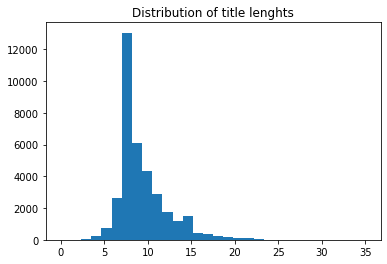

Maximum number of tokens per text:  35


In [13]:
# BY MY OWN CHOICE:
# Adjust the maximum number of tokens per text according to the length of the title.
# If much bigger, we can adjust the maximum number of tokens per text according to the
# upper outliers boundary, as seen in section "Feature Engineering - Enriching the Title"
lenghts_ = []

for title in x_train_seq:
    lenghts_.append(len(title))

lenghts_ = np.array(lenghts_)

# Plot distribution of lenghts
plt.title('Distribution of title lenghts')
n, bins, patches = plt.hist(lenghts_, bins=30)
plt.show()

max_length = np.max(lenghts_) # max(lenght value) is selected, if not very big
trunc_type = 'post' # If the number of tokens per text is exceeded, it is truncated.
padding_type = 'post' # If short, 0s are added.

print('Maximum number of tokens per text: ', max_length)

x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [14]:
# Use glove.6B.50d by Stanford University
pre_trained_embedding = "glove.6B.50d.txt"
embedding_dim = 50  # embedding dimension

# transform embedding using tokenized indexes. This is, transform the
# bedded word to same oken your data had
embeddings_index = {}

# Parse embedding
f = open(pre_trained_embedding, encoding="utf8")
for line in f:
    values = line.split() # the actual vector representation
    word = values[0] # the original word
    # place vector representation in the value where "key" equals "word"
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len_word_index + 1, embedding_dim))

# Store words not found in the embedding.
not_found_words = []

for word, i in word_index.items(): # for each word in word_index dictionary
    embedding_vector = embeddings_index.get(word) # capture vector reprsntation using "word" as key
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        not_found_words.append(word)
        
print(len(not_found_words), " of the words have not been found in", pre_trained_embedding)

597  of the words have not been found in glove.6B.50d.txt


# Defining architectures

In the following architectures Adam has been used as the optimizer, as it combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. Source: [Machine Learning Mastery](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20combines%20the%20best%20properties,do%20well%20on%20most%20problems)


## Model 1

Sequential model, Embedding layer followed by LSTM bidirectional layers, then 'dense_layers_' dense layers.

In [15]:
def make_model1(bidirectional_layers_ = 1
                , bidirectional_dropout_ = 0.0
                , dense_layers_ = 1
                , dense_dropout_ = 0.0
                , lr_ = 0.001
                , loss_='binary_crossentropy'
                , output_bias_ = None
                , verbose = 1):
    
    model = Sequential()
    model.add(Embedding(input_dim = len_word_index + 1 # the entering token j (j its a number) 
        #finds it´s word representation in the j row, where rows are "len_word_index + 1".
                       , output_dim = embedding_dim # word representation dimension. Question
                       , weights = [embedding_matrix] # pretrained embedding
                       , input_length = max_length # Expected text size
                       , trainable = False)) # Trainable = True when embedding elegible to change
    
    for i in range(0,bidirectional_layers_):
        # return_sequences -> last bidirectional doesnt return requences
        return_sequences = ((bidirectional_layers_ - i) != 1)
        model.add(Bidirectional(LSTM(embedding_dim
                                 , activation = 'relu'
                                 , dropout = bidirectional_dropout_ # regularization 
                                 , recurrent_dropout = bidirectional_dropout_ # regularization
                                 , return_sequences = return_sequences))
                  )

    for i in range(0,dense_layers_):
        model.add(Dense(embedding_dim, activation='relu')) # dense layers
        if dense_dropout_ != 0.0:
            model.add(Dropout(dense_dropout_)) # regularization
            
    # bias the cost function
    if output_bias_ is not None:
        output_bias_ = initializers.Constant(output_bias_)
    else:
        output_bias_ = 'zeros'

    # Just let it be controlled via function call argument
    if loss_=='binary_crossentropy':
        model.add(Dense(1
                        , activation='sigmoid'
                        , bias_initializer = output_bias_))

        model.compile(loss = 'binary_crossentropy' # return prob dist
                      , optimizer = Adam(learning_rate=lr_)
                      , metrics = ['accuracy'])
    else:
        model.add(Dense(2
                        , activation='softmax'
                        , bias_initializer = output_bias_))

        model.compile(loss = 'sparse_categorical_crossentropy' # return prob dist
                      , optimizer = Adam(learning_rate=lr_)
                      , metrics = ['accuracy'])
    # Print model info
    if verbose:
        print('bidirectional_layers :' + str(bidirectional_layers_))
        print('bidirectional_dropout :' + str(bidirectional_dropout_))
        print('dense_layers :' + str(dense_layers_))
        print('dense_dropout :' + str(dense_dropout_))
        print('lr :' + str(lr_))
        print(model.summary())
        
    return model

In [16]:
model_example_1 = make_model1(verbose=True)

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 50)            949450    
                                                                 
 bidirectional (Bidirectiona  (None, 100)              40400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 994,951
Trainable params: 45,501
Non-trainable params: 949,450
_________________________________________________________________
None


## Model 2

Inspired in the architecture proposed by Sava Kalbachou (@thinline72) to get the 12th place in Toxic Comment Classification Challenge. Model's 1 based architecture, incorporating **Spatial Dropout and Global Average Pooling**. Click [here](https://github.com/thinline72/toxic) for more information.

In [17]:
def make_model2(bidirectional_layers_ = 1
                , bidirectional_dropout_ = 0.0
                , dense_layers_ = 1
                , dense_dropout_ = 0.0
                , lr_ = 0.001
                , loss_='binary_crossentropy'
                , output_bias_ = None
                , verbose = 1):
    
    model = Sequential()
    model.add(Embedding(input_dim = len_word_index + 1 # the entering token j (j its a number) 
        #finds it´s word representation in the j row, where rows are "len_word_index + 1".
                       , output_dim = embedding_dim # word representation dimension. Question
                       , weights = [embedding_matrix] # pretrained embedding
                       , input_length = max_length # Expected text size
                       , trainable = False)) # Trainable = True when embedding elegible to change
    
    #1-d spatial dropout is the standard for embedding layers
    #it can be used in nlp tasks as well
    model.add(tf.keras.layers.SpatialDropout1D(0.3))  # 0.3 is empirically set
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim
                                                         , return_sequences=True
                                                        )))
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling1D
    model.add(tf.keras.layers.GlobalAvgPool1D())
    
    for i in range(0,dense_layers_):
        model.add(Dense(embedding_dim, activation='relu')) # dense layers
        if dense_dropout_ != 0.0:
            model.add(Dropout(dense_dropout_)) # regularization
            
    # bias the cost function
    if output_bias_ is not None:
        output_bias_ = initializers.Constant(output_bias_)
    else:
        output_bias_ = 'zeros'    
    
    # Just let it be controlled via function call argument
    if loss_=='binary_crossentropy':
        model.add(Dense(1
                        , activation='sigmoid'
                        , bias_initializer = output_bias_))

        model.compile(loss = 'binary_crossentropy' # return prob dist
                      , optimizer = Adam(learning_rate=lr_)
                      , metrics = ['accuracy'])
    else:
        model.add(Dense(2
                        , activation='softmax'
                        , bias_initializer = output_bias_))

        model.compile(loss = 'sparse_categorical_crossentropy' # return prob dist
                      , optimizer = Adam(learning_rate=lr_)
                      , metrics = ['accuracy'])
    # Print model info
    if verbose:
        print('bidirectional_layers :' + str(bidirectional_layers_))
        print('bidirectional_dropout :' + str(bidirectional_dropout_))
        print('dense_layers :' + str(dense_layers_))
        print('dense_dropout :' + str(dense_dropout_))
        print('lr :' + str(lr_))
        print(model.summary())
        
    return model

In [18]:
model_example_2 = make_model2(verbose=True)

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 50)            949450    
                                                                 
 spatial_dropout1d (SpatialD  (None, 35, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 35, 100)          40400     
 nal)                                                            
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)        

# Search for some optimal hyperparameters related to the architectures:
- **Number of dense layers.**
- **Loss function -> Nº of neurons and Activation functions for the last layer**: Tuning the loss function as 'binary_crossentropy' or 'sparse_categorical_crossentropy' let us control if 1 neuron with Sigmoid or 2 neurons with softmax is chosen in the architecture of the NN. For this reason, it is considered an architecture issue and is optimized in this section.

Other parameters such as learning rate, batch size or drop_out will be optimized by gridsearch in the following sections.

It was first tried to perform method *sklearn.model_selection.GridSearchCV* using *scikeras.wrappers.KerasRegressor*, but it was found to be interesting to visualize the training plots for each model, so it was done **iteratively**.

In [19]:
param_grid1 = {"dense_layers": [1, 2, 3]
          , "loss": ['binary_crossentropy', 'sparse_categorical_crossentropy']
         }

keys = param_grid1.keys()
values = (param_grid1[key] for key in keys)
# make a list of dictionaries containing every possible combination in the grid as a dict
param_grid1 = [dict(zip(keys, param_grid1)) for param_grid1 in itertools.product(*values)]

print('Proposed ' + str(len(param_grid1)) + ' models:')

for i, pair in enumerate(param_grid1):
    print(i,'~',pair)

Proposed 6 models:
0 ~ {'dense_layers': 1, 'loss': 'binary_crossentropy'}
1 ~ {'dense_layers': 1, 'loss': 'sparse_categorical_crossentropy'}
2 ~ {'dense_layers': 2, 'loss': 'binary_crossentropy'}
3 ~ {'dense_layers': 2, 'loss': 'sparse_categorical_crossentropy'}
4 ~ {'dense_layers': 3, 'loss': 'binary_crossentropy'}
5 ~ {'dense_layers': 3, 'loss': 'sparse_categorical_crossentropy'}


In [20]:
# Number of epochs for the current experiment
epochs = 20

## Over Model 1

Iterative Search

1 de 6 - {'dense_layers': 1, 'loss': 'binary_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 50)            951100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 996,601
Trainable params: 45,501
Non-trainable params: 951,100
___________________

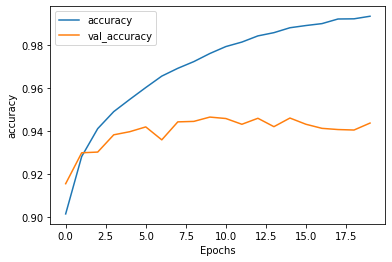

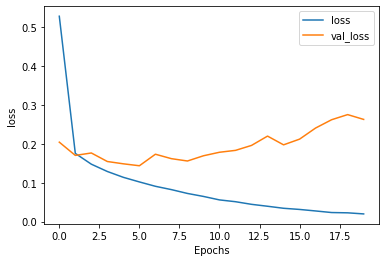

Time elapsed: 0:06:26

2 de 6 - {'dense_layers': 1, 'loss': 'sparse_categorical_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 50)            951100    
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 2)                 102       
                                                                 
Total params: 996,652
Trainable params: 45,552
Non-trainable 

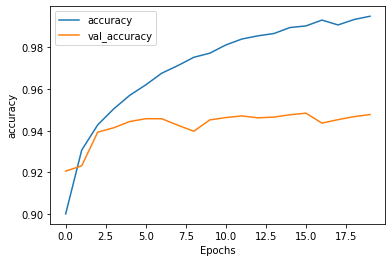

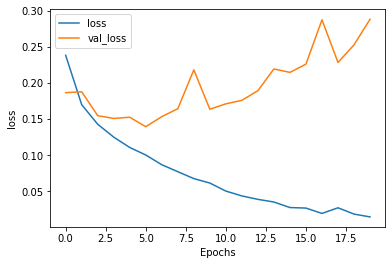

Time elapsed: 0:06:19

3 de 6 - {'dense_layers': 2, 'loss': 'binary_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :2
dense_dropout :0.0
lr :0.001
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 35, 50)            951100    
                                                                 
 bidirectional_4 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
       

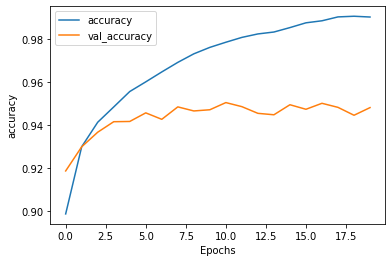

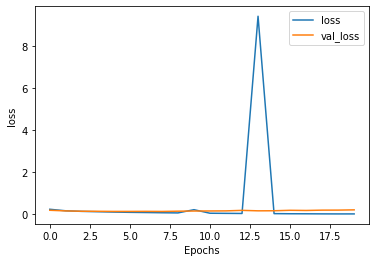

Time elapsed: 0:06:18

4 de 6 - {'dense_layers': 2, 'loss': 'sparse_categorical_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :2
dense_dropout :0.0
lr :0.001
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 35, 50)            951100    
                                                                 
 bidirectional_5 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 2)                 102   

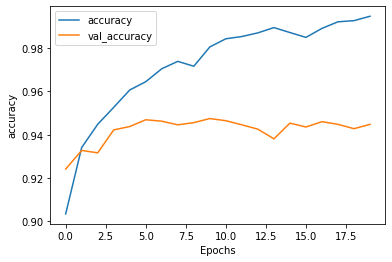

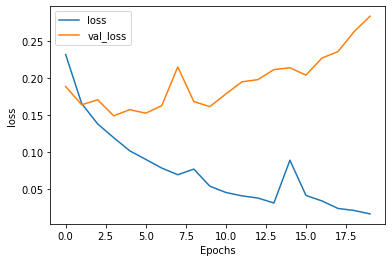

Time elapsed: 0:06:18

5 de 6 - {'dense_layers': 3, 'loss': 'binary_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :3
dense_dropout :0.0
lr :0.001
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 35, 50)            951100    
                                                                 
 bidirectional_6 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
       

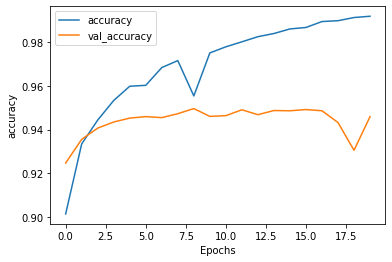

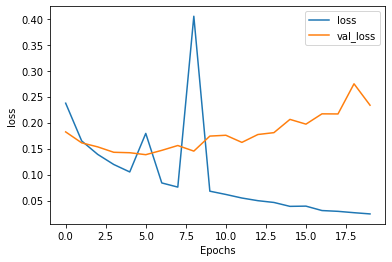

Time elapsed: 0:06:11

6 de 6 - {'dense_layers': 3, 'loss': 'sparse_categorical_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :3
dense_dropout :0.0
lr :0.001
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 35, 50)            951100    
                                                                 
 bidirectional_7 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 50)                5050      
                                                                 
 dense_19 (Dense)            (None, 50)                2550      
                                                                 
 dense_20 (Dense)            (None, 50)                2550  

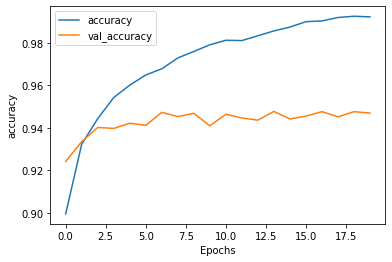

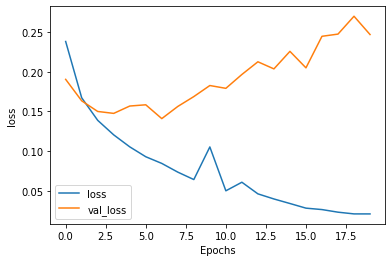

Time elapsed: 0:06:24

Wall time: 37min 55s


In [21]:
%%time

# Create a copy for this particular model
param_grid1_model1 = copy.deepcopy(param_grid1)
# Total iterations
total_iter = len(param_grid1_model1)

for j in range(0, total_iter):

    print(f'{j+1} de {total_iter} - {param_grid1_model1[j]}')
    
    start_time = time.time()
    
    dense_layers = param_grid1_model1[j].get("dense_layers")
    loss = param_grid1_model1[j].get("loss")
    
    
    model_1 = make_model1(dense_layers_ = dense_layers
                                  , loss_ = loss
                                  , verbose=True)

    history1 = model_1.fit(x_train_pad, y_train_seq
                        , epochs=epochs
                        , validation_data=(x_val_pad, y_val_seq)
                        , verbose=0)  # no verboseness 
    
    plot_history_train(history1, "accuracy")
    plot_history_train(history1, "loss")
    
    mae = pd.DataFrame.from_dict(history1.history)['val_accuracy'].iloc[-1]
    param_grid1_model1[j].update( {"val_accuracy":mae})
    
    elapsed_time = time.time() - start_time
    print(f'Time elapsed: {datetime.timedelta(seconds=round(elapsed_time))}\n')    
    
results1 = pd.DataFrame(param_grid1_model1)

## Over Model 2

Iterative Search

1 de 6 - {'dense_layers': 1, 'loss': 'binary_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_8 (Bidirectio  (None, 35, 100)          40400     
 nal)                                                            
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                              

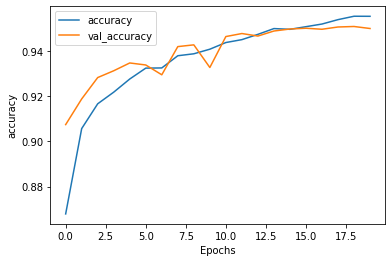

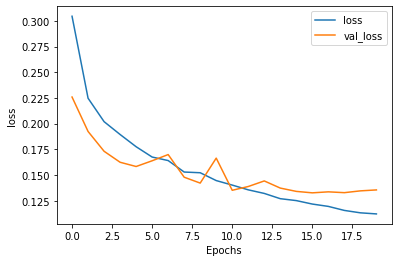

Time elapsed: 0:06:19

2 de 6 - {'dense_layers': 1, 'loss': 'sparse_categorical_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_9 (Bidirectio  (None, 35, 100)          40400     
 nal)                                                            
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                                    

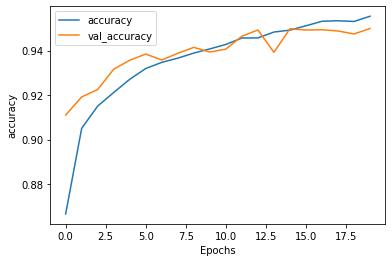

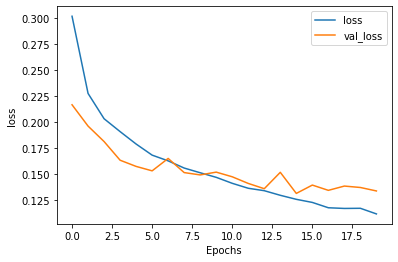

Time elapsed: 0:06:37

3 de 6 - {'dense_layers': 2, 'loss': 'binary_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :2
dense_dropout :0.0
lr :0.001
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_10 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_3   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
      

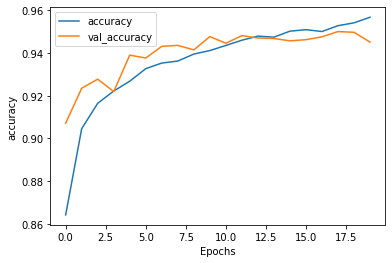

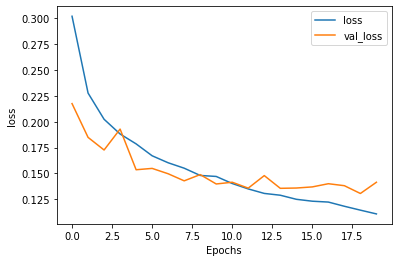

Time elapsed: 0:06:34

4 de 6 - {'dense_layers': 2, 'loss': 'sparse_categorical_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :2
dense_dropout :0.0
lr :0.001
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_11 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_4   (None, 100)              0         
 (GlobalAveragePooling1D)                                   

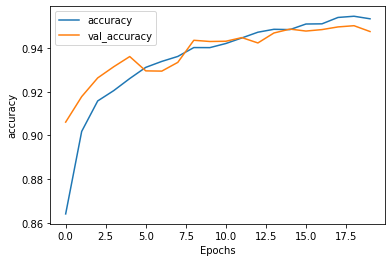

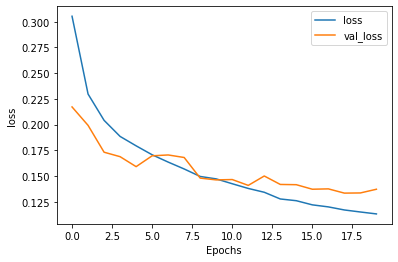

Time elapsed: 0:09:34

5 de 6 - {'dense_layers': 3, 'loss': 'binary_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :3
dense_dropout :0.0
lr :0.001
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_12 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_5   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
      

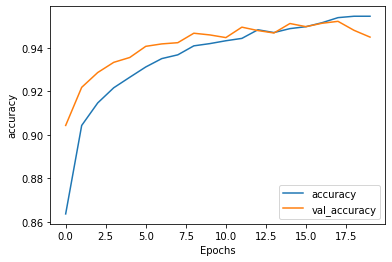

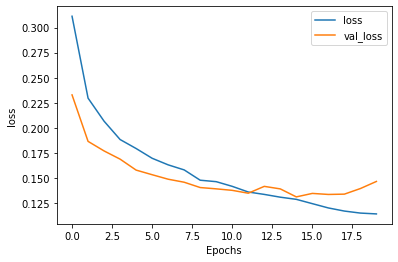

Time elapsed: 0:08:46

6 de 6 - {'dense_layers': 3, 'loss': 'sparse_categorical_crossentropy'}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :3
dense_dropout :0.0
lr :0.001
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_13 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_6   (None, 100)              0         
 (GlobalAveragePooling1D)                                   

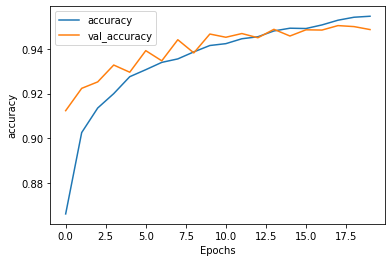

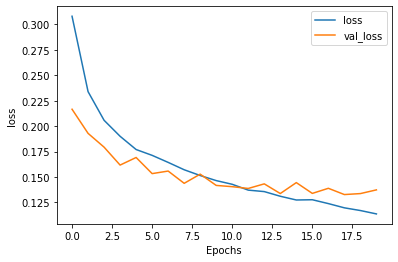

Time elapsed: 0:10:50

Wall time: 48min 39s


In [22]:
%%time

# Create a copy for this particular model
param_grid1_model2 = copy.deepcopy(param_grid1)
# Total iterations
total_iter = len(param_grid1_model2)

for j in range(0, total_iter):

    print(f'{j+1} de {total_iter} - {param_grid1_model2[j]}')
    start_time = time.time()
    
    dense_layers = param_grid1_model2[j].get("dense_layers")
    loss = param_grid1_model2[j].get("loss")
    
    
    model_2 = make_model2(dense_layers_ = dense_layers
                                  , loss_ = loss
                                  , verbose=True)

    history2 = model_2.fit(x_train_pad, y_train_seq
                        , epochs=epochs
                        , validation_data=(x_val_pad, y_val_seq)
                        , verbose=0)  # no verboseness 
    
    plot_history_train(history2, "accuracy")
    plot_history_train(history2, "loss")
    
    mae = pd.DataFrame.from_dict(history2.history)['val_accuracy'].iloc[-1]
    param_grid1_model2[j].update( {"val_accuracy":mae})
    
    elapsed_time = time.time() - start_time
    print(f'Time elapsed: {datetime.timedelta(seconds=round(elapsed_time))}\n')    
    
results2 = pd.DataFrame(param_grid1_model2)

## Comparison of results and architecture selection

In [23]:
results1['model'] = 1
results2['model'] = 2
cmp = pd.concat([results1, results2], ignore_index=True).sort_values(['val_accuracy'],ascending = False)
cmp

,dense_layers,loss,val_accuracy,model
6,1,binary_crossentropy,0.950000,2
7,1,sparse_categorical_crossentropy,0.949889,2
11,3,sparse_categorical_crossentropy,0.948775,2
2,2,binary_crossentropy,0.948107,1
1,1,sparse_categorical_crossentropy,0.947773,1
9,2,sparse_categorical_crossentropy,0.947661,2
5,3,sparse_categorical_crossentropy,0.946993,1
4,3,binary_crossentropy,0.945880,1
8,2,binary_crossentropy,0.945100,2
10,3,binary_crossentropy,0.944878,2


**MODEL 2 OUTPERFORMS MODEL 1! So we select this architecture for now on as base model**:

In [24]:
model_base = make_model2(dense_layers_ = 1
                         , loss_ = 'binary_crossentropy'
                         , verbose = 1)

history_base = model_base.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=0)  # no verboseness 

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_14 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_7   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_40 (Dense)      

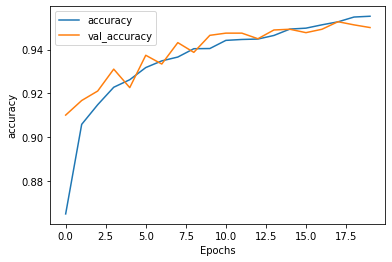

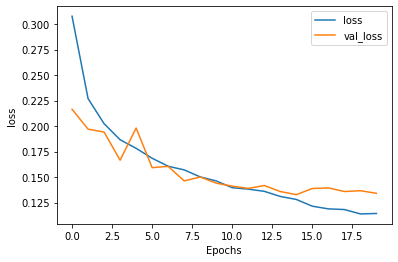

In [25]:
plot_history_train(history_base, "accuracy")
plot_history_train(history_base, "loss")

# Tuning the rest of parameters over the best model

The following parameters are then optimized over the best model:

- **Learning rate**
- **Batch size**
- **Dropout**

These parameters are optimized **independently**. This decision was made in order to be able to study the isolated effect of the variation in each one.

## Learning rate

In [27]:
param_grid3 = {"lr": [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001]
         }

keys = param_grid3.keys()
values = (param_grid3[key] for key in keys)
# make a list of dictionaries containing every possible combination in the grid as a dict
param_grid3 = [dict(zip(keys, param_grid3)) for param_grid3 in itertools.product(*values)]

print('Proposed ' + str(len(param_grid3)) + ' models:')
param_grid3

Proposed 6 models:


[{'lr': 0.1},
 {'lr': 0.01},
 {'lr': 0.005},
 {'lr': 0.001},
 {'lr': 0.0005},
 {'lr': 0.0001}]

1 de 6 - {'lr': 0.1}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.1
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_15 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_8   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 den

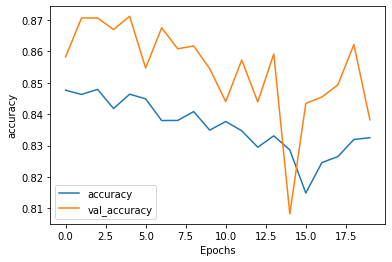

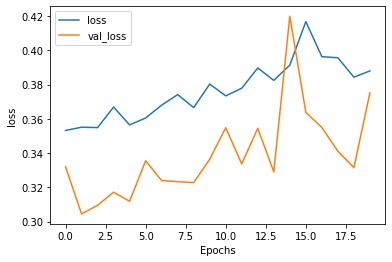

Time elapsed: 0:10:47

2 de 6 - {'lr': 0.01}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.01
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_16 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_9   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                             

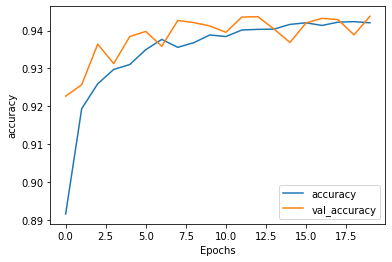

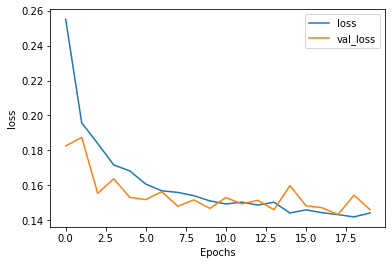

Time elapsed: 0:13:54

3 de 6 - {'lr': 0.005}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.005
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_17 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_10  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                           

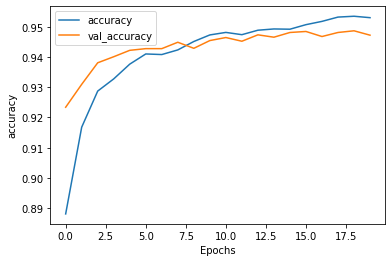

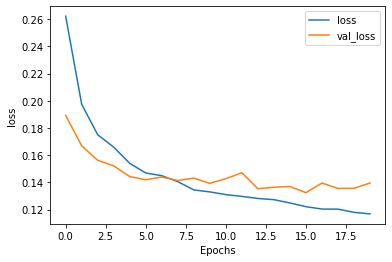

Time elapsed: 0:14:52

4 de 6 - {'lr': 0.001}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_11 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_18 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_11  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                           

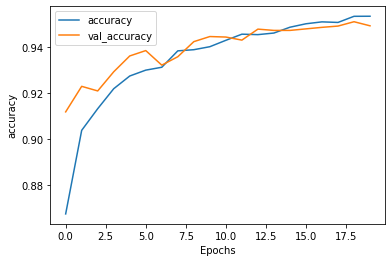

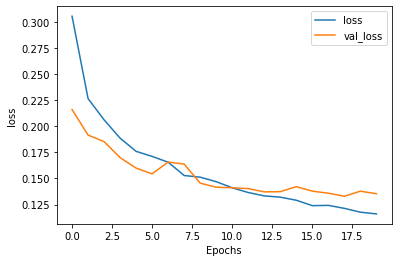

Time elapsed: 0:17:15

5 de 6 - {'lr': 0.0005}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.0005
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_12 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_19 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_12  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                         

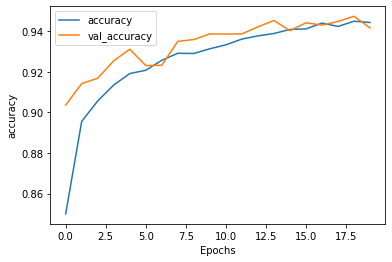

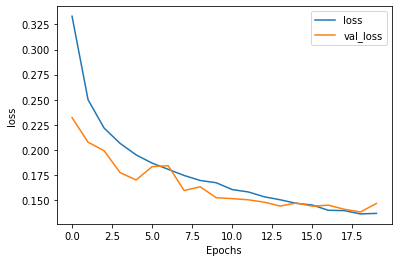

Time elapsed: 0:30:14

6 de 6 - {'lr': 0.0001}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.0001
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_13 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_20 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_13  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                         

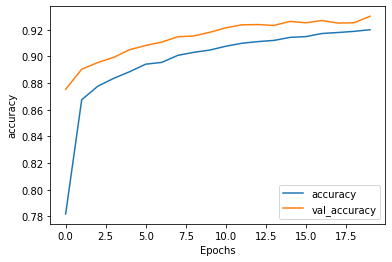

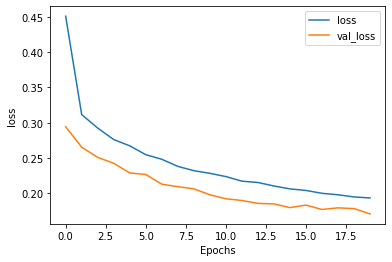

Time elapsed: 0:19:09

Wall time: 1h 46min 10s


In [28]:
%%time

# Total iterations
total_iter = len(param_grid3)

for j in range(0, total_iter):

    print(f'{j+1} de {total_iter} - {param_grid3[j]}')
    
    start_time = time.time()
    
    lr = param_grid3[j].get("lr")

    model_aux = make_model2(dense_layers_ = 1
                            , loss_ = 'binary_crossentropy'
                            , lr_ = lr
                            , verbose = 1)

    history_aux = model_aux.fit(x_train_pad, y_train_seq
                        , epochs=epochs
                        , validation_data=(x_val_pad, y_val_seq)
                        , verbose=0)  # no verboseness 
    
    plot_history_train(history_aux, "accuracy")
    plot_history_train(history_aux, "loss")
    met = pd.DataFrame.from_dict(history_aux.history)['val_accuracy'].iloc[-1]
    param_grid3[j].update({"val_accuracy":met})
    
    elapsed_time = time.time() - start_time
    print(f'Time elapsed: {datetime.timedelta(seconds=round(elapsed_time))}\n') 
    
results3 = pd.DataFrame(param_grid3)

**Learning rate effect analysis:**

To understand the learning rate in the framework of gradient descent, we can imagine we are at the top of a mountain and wish to reach the point of minimum altitude. We do not have access to the terrain map and cannot look around us. In this situation the only thing we can do is to feel with our foot the slope of the place where we are and move to where the slope descends more intensively. In this way, the learning rate defines how much we advance in each step, or in other words, how much the gradient affects the updating of the weights. [This example belongs to DotCSV](https://www.youtube.com/watch?v=A6FiCDoz8_4). Smaller learning rates will require more training epochs, as the changes in weights are smaller at each update, while larger learning rates produce rapid changes and require fewer training epochs.

As we can see in the graphs, for **high learning rates** the steps it takes are so long that the algorithm is unable to reach the minimum cost zone (and therefore we see some points where the error fluctuates abruptly). On the other hand, for **small learning rates**, we see that the point gradually approaches the minimum cost zone, but it get stuck in the local minimum, presenting worse metrics than higher values. Intermediate values, such as 0.001 or 0.005 are more appropriate since the optimization algorithm works better and more validation accuracy is observed.

In [29]:
results3.sort_values(['val_accuracy'],ascending=False)

,lr,val_accuracy
3,0.0010,0.949332
2,0.0050,0.947216
1,0.0100,0.943764
4,0.0005,0.941537
5,0.0001,0.930178
0,0.1000,0.838196


## Batch size

In [30]:
param_grid4 = {"batch_size": [16, 32, 64, 128, 256, 512]
         }

keys = param_grid4.keys()
values = (param_grid4[key] for key in keys)
# make a list of dictionaries containing every possible combination in the grid as a dict
param_grid4 = [dict(zip(keys, param_grid4)) for param_grid4 in itertools.product(*values)]

print('Proposed ' + str(len(param_grid4)) + ' models:')
param_grid4

Proposed 6 models:


[{'batch_size': 16},
 {'batch_size': 32},
 {'batch_size': 64},
 {'batch_size': 128},
 {'batch_size': 256},
 {'batch_size': 512}]

1 de 6 - {'batch_size': 16}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_14 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_21 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_14  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                             

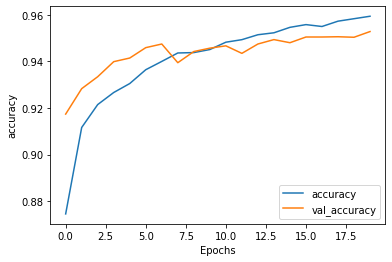

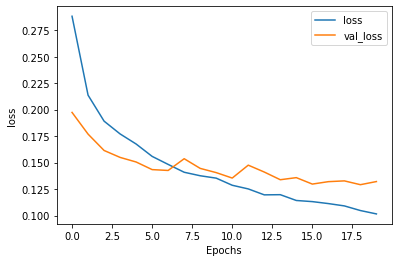

Time elapsed: 0:27:54

2 de 6 - {'batch_size': 32}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_15 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_22 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_15  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                      

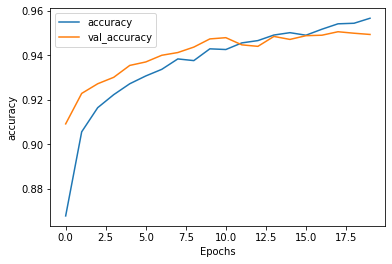

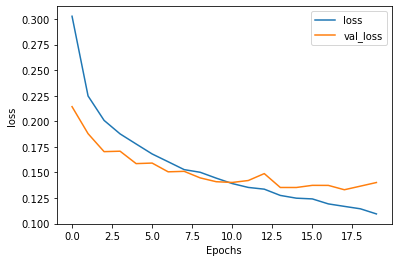

Time elapsed: 0:19:53

3 de 6 - {'batch_size': 64}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_16 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_23 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_16  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                      

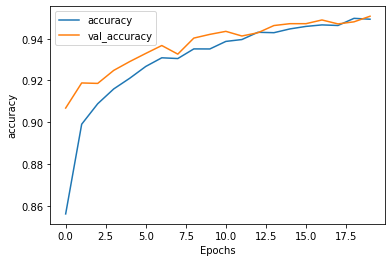

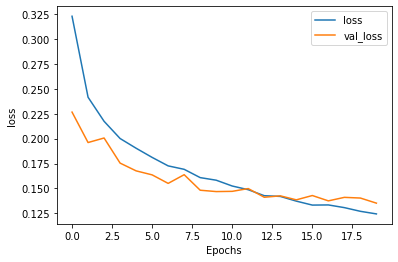

Time elapsed: 0:19:13

4 de 6 - {'batch_size': 128}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_17 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_24 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_17  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                     

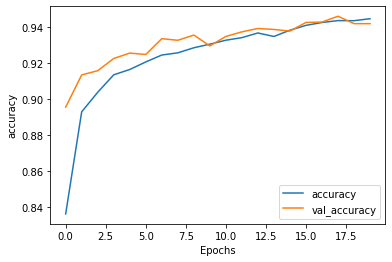

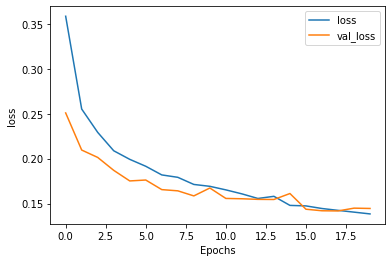

Time elapsed: 0:19:06

5 de 6 - {'batch_size': 256}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_18 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_25 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_18  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                     

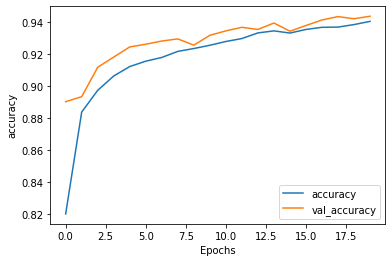

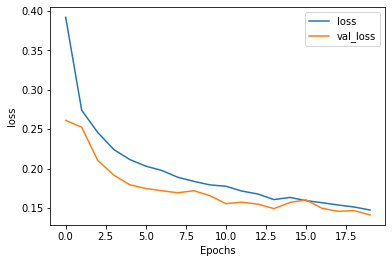

Time elapsed: 0:13:57

6 de 6 - {'batch_size': 512}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_19 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_26 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_19  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                     

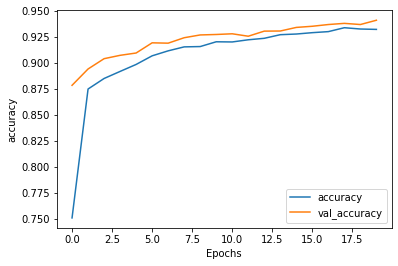

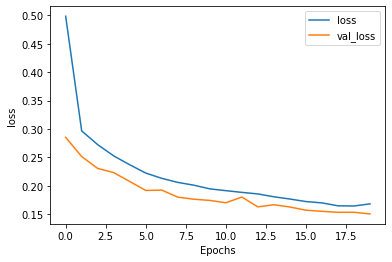

Time elapsed: 0:18:58

Wall time: 1h 59min


In [31]:
%%time

# Total iterations
total_iter = len(param_grid4)

for j in range(0, total_iter):

    print(f'{j+1} de {total_iter} - {param_grid4[j]}')
    
    start_time = time.time()
    
    batch_size_ = param_grid4[j].get("batch_size")

    model_aux = make_model2(dense_layers_ = 1
                            , loss_ = 'binary_crossentropy'
                            , verbose = 1)

    history_aux = model_aux.fit(x_train_pad, y_train_seq
                        , epochs=epochs
                        , batch_size = batch_size_
                        , validation_data=(x_val_pad, y_val_seq)
                        , verbose=0)  # no verboseness 

    plot_history_train(history_aux, "accuracy")
    plot_history_train(history_aux, "loss")
    met = pd.DataFrame.from_dict(history_aux.history)['val_accuracy'].iloc[-1]
    param_grid4[j].update({"val_accuracy":met})
    
    elapsed_time = time.time() - start_time
    print(f'Time elapsed: {datetime.timedelta(seconds=round(elapsed_time))}\n') 
    
results4 = pd.DataFrame(param_grid4)

**Batch size effect analysis:**

Batch size is the number of examples from the training set used in the estimate of the error gradient before the weights are updated. Batch size is a typically optimized parameter, as it impacts upon how fast a model learns. Smaller batches pass through the network faster and with less variability and, generally, smaller batch sizes offer higher regularization effect and lower validation error. Source: [Machine Learning Mastery](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/).

As we can see in the graphs, **smaller batch sizes** generalize well on the validation set, but take much longer to train. On the other hand, **higher batch sizes** are faster in train, but tend to achieve less accuracy in validation set. The best value for the batch size has turned out to be 16.


In [32]:
results4.sort_values(['val_accuracy'],ascending=False)

,batch_size,val_accuracy
0,16,0.952784
2,64,0.950779
1,32,0.949443
4,256,0.943430
3,128,0.942094
5,512,0.940869


## Dropout

In [33]:
param_grid5 = {"dense_dropout": [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
         }

keys = param_grid5.keys()
values = (param_grid5[key] for key in keys)
# make a list of dictionaries containing every possible combination in the grid as a dict
param_grid5 = [dict(zip(keys, param_grid5)) for param_grid5 in itertools.product(*values)]

print('Proposed ' + str(len(param_grid5)) + ' models:')
param_grid5

Proposed 6 models:


[{'dense_dropout': 0.0},
 {'dense_dropout': 0.01},
 {'dense_dropout': 0.05},
 {'dense_dropout': 0.1},
 {'dense_dropout': 0.2},
 {'dense_dropout': 0.3}]

1 de 6 - {'dense_dropout': 0.0}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_20 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_27 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_20  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                         

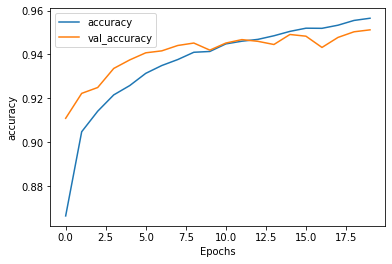

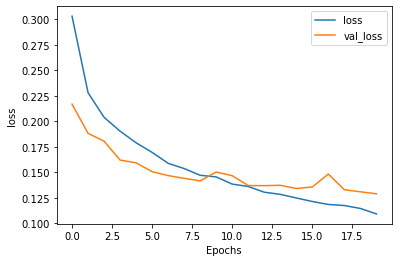

Time elapsed: 0:23:16

2 de 6 - {'dense_dropout': 0.01}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.01
lr :0.001
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_21 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_28 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_21  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                

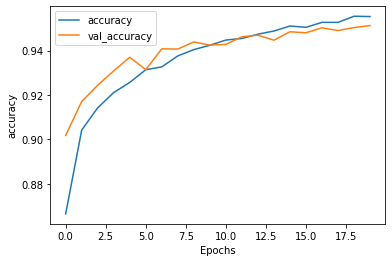

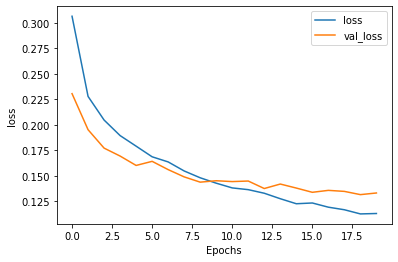

Time elapsed: 0:23:50

3 de 6 - {'dense_dropout': 0.05}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.05
lr :0.001
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_22 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_29 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_22  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                

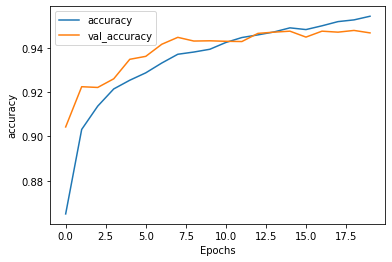

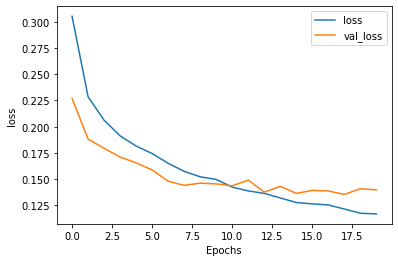

Time elapsed: 0:24:53

4 de 6 - {'dense_dropout': 0.1}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.1
lr :0.001
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_23 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_30 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_23  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                  

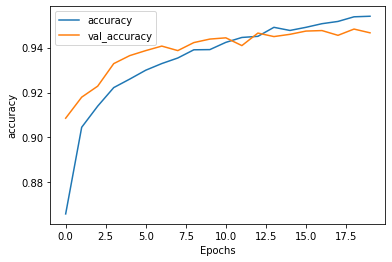

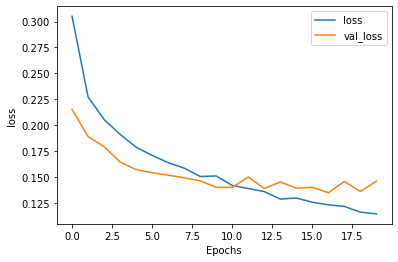

Time elapsed: 0:25:00

5 de 6 - {'dense_dropout': 0.2}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.2
lr :0.001
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_24 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_31 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_24  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                  

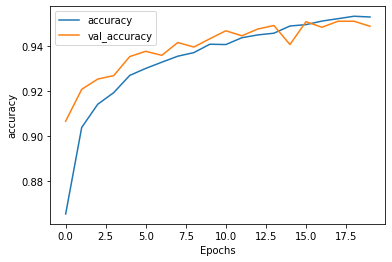

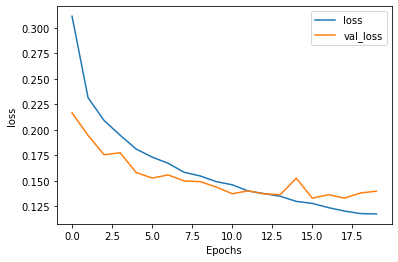

Time elapsed: 0:24:01

6 de 6 - {'dense_dropout': 0.3}
bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.3
lr :0.001
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 35, 50)            951100    
                                                                 
 spatial_dropout1d_25 (Spati  (None, 35, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_32 (Bidirecti  (None, 35, 100)          40400     
 onal)                                                           
                                                                 
 global_average_pooling1d_25  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                  

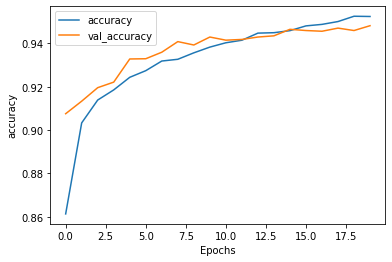

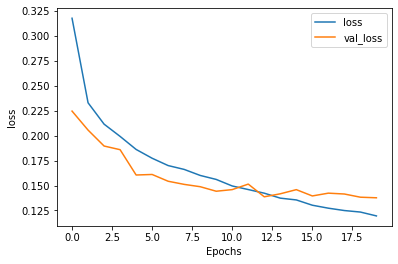

Time elapsed: 0:24:37

Wall time: 2h 25min 35s


In [34]:
%%time

# Total iterations
total_iter = len(param_grid5)

for j in range(0, total_iter):

    print(f'{j+1} de {total_iter} - {param_grid5[j]}')
    
    start_time = time.time()
    
    dense_dropout = param_grid5[j].get("dense_dropout")

    model_aux = make_model2(dense_layers_ = 1
                            , loss_ = 'binary_crossentropy'
                            , dense_dropout_ = dense_dropout
                            , verbose = 1)

    history_aux = model_aux.fit(x_train_pad, y_train_seq
                        , epochs=epochs
                        , validation_data=(x_val_pad, y_val_seq)
                        , verbose=0)  # no verboseness 
    
    plot_history_train(history_aux, "accuracy")
    plot_history_train(history_aux, "loss")
    met = pd.DataFrame.from_dict(history_aux.history)['val_accuracy'].iloc[-1]
    param_grid5[j].update({"val_accuracy":met})
    
    elapsed_time = time.time() - start_time
    print(f'Time elapsed: {datetime.timedelta(seconds=round(elapsed_time))}\n') 
    
results5 = pd.DataFrame(param_grid5)

**Dropout effect analysis:**

Dropout randomly turns off nodes during training, breaking up situations where network layers co-adapt to correct mistakes from prior layers, in turn making the model more robust, but these co-adaptations do not generalize to unseen data. Then, it can be considered a computationally cheap and effective regularization method. Source: [Machine Learning Mastery](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/).

As we can see in the graphs, the chosen network does not seem to be very sensitive to variations in dropout rate, but no dropout or a dropout rate of 0.01 tends to achieve higher accuracy in validation.

In [35]:
results5.sort_values(['val_accuracy'],ascending=False)

,dense_dropout,val_accuracy
0,0.00,0.951225
1,0.01,0.951225
4,0.20,0.948775
5,0.30,0.948218
2,0.05,0.946659
3,0.10,0.946548


# Base model selection

To be able to determine the impact of some changes in external hyperparameters and as a consequence of feature engineering, we 'update' the base moodel by chosing a good combination of hyperparameters based on what was previously seen.

In [38]:
# Number of epochs for the current experiment. We reduce to 10 epochs, few
# but just enough to compare it with the heavy models that will be generated below.
epochs = 10

In [40]:
model_base = make_model2(dense_layers_ = 1
                        , loss_ = 'binary_crossentropy'
                        , lr_ = 0.001
                        , dense_dropout_ = 0.01
                        , verbose = 1)

history_base = model_base.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , batch_size=16                   
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=0)  # no verboseness 

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.01
lr :0.001
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 35, 50)            949450    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 35, 100)          40400     
 nal)                                                            
                                                                 
 global_average_pooling1d_3   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)       

# Change in the external hyperparameters of the model.

Change the padding and embedding and analyse the impact on model's performance.

## From 'post' padding to 'pre'

In [41]:
padding_type = 'pre'

# Create new training pre-padded test sets
x_train_pad_cmp1 = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_val_pad_cmp1 = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [42]:
# Train the same base model with pre-padded data
model_cmp1 = make_model2(dense_layers_ = 1
                         , loss_ = 'binary_crossentropy'
                         , lr_ = 0.001
                         , dense_dropout_ = 0.01
                         , verbose = 1)

history_cmp1 = model_cmp1.fit(x_train_pad_cmp1, y_train_seq
                    , epochs=epochs
                    , batch_size=16
                    , validation_data=(x_val_pad_cmp1, y_val_seq)
                    , verbose=0)

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.01
lr :0.001
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 35, 50)            949450    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_5 (Bidirectio  (None, 35, 100)          40400     
 nal)                                                            
                                                                 
 global_average_pooling1d_4   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)      

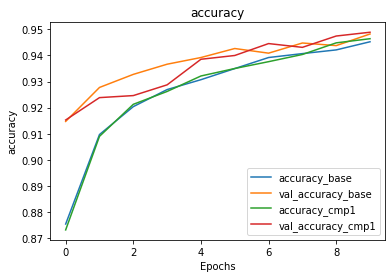

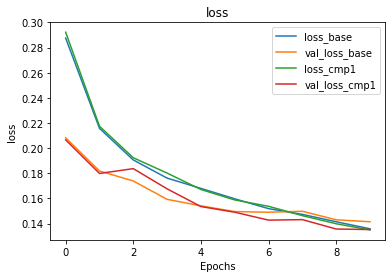

In [43]:
# Plot comparison
for metric in ['accuracy','loss']:
    plt.title(metric)
    plt.plot(history_base.history[metric])
    plt.plot(history_base.history['val_'+metric])
    plt.plot(history_cmp1.history[metric])
    plt.plot(history_cmp1.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric+'_base','val_'+metric+'_base',metric+'_cmp1', 'val_'+metric+'_cmp1'])
    plt.show()

As can be seen in the graphs, the performance of the model is slightly improved by replacing 'pre' padding with 'post'. Perhaps this is due to a proper setting of the max_lenght parameter that we have fixed according to the current sample, so the effect of applying 'pre' or 'post' padding is reduced.

## Richer Embedding

Another embedding from Stanford University, **42B.300d**, has been used, replacing the prior one to check this change's impact on accuracy. The file can be downloaded [here](https://github.com/stanfordnlp/GloVe).

In [44]:
%%time

# 42B tokens, 1.M vocabulary
pre_trained_embedding_cmp2 = "glove.42B.300d.txt"
embedding_dim_cmp2 = 300  # embedding dimension

# transform embedding using tokenized indexes. This is, transform the
# bedded word to same oken your data had

embeddings_index_cmp2 = {}

# Parse embedding
f = open(pre_trained_embedding_cmp2, encoding="utf8")
for line in f:
    values = line.split() # the actual vector representation
    word = values[0] # the original word
    # place vector representation in the value where "key" equals "word"
    embeddings_index_cmp2[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix_cmp2 = np.random.random((len_word_index + 1, embedding_dim_cmp2))

# Store words not found in the embedding.
not_found_words_cmp2 = []

for word, i in word_index.items(): # for each word in word_index dictionary
    embedding_vector = embeddings_index_cmp2.get(word)# capture vector reprsntation using "word" as key
    if embedding_vector is not None:
        embedding_matrix_cmp2[i] = embedding_vector
    else:
        not_found_words_cmp2.append(word)
        
print(len(not_found_words_cmp2), " of the words have not been found in", pre_trained_embedding_cmp2)

335  of the words have not been found in glove.42B.300d.txt
Wall time: 2min 49s


While in the original embedding, there were more words that were not found:

In [45]:
print(len(not_found_words), " of the words have not been found in", pre_trained_embedding)

597  of the words have not been found in glove.6B.50d.txt


**Re-defining the funcion, including the new embedding vars. in make_model_function**:

In [46]:
def make_model2_cmp2(bidirectional_layers_ = 1
                , bidirectional_dropout_ = 0.0
                , dense_layers_ = 1
                , dense_dropout_ = 0.0
                , lr_ = 0.001
                , loss_='binary_crossentropy'
                , output_bias_ = None
                , verbose = 1):
    
    model = Sequential()
    model.add(Embedding(input_dim = len_word_index + 1 # the entering token j (j its a number) 
        #finds it´s word representation in the j row, where rows are "len_word_index + 1".
                       , output_dim = embedding_dim_cmp2 # word representation dimension. Question
                       , weights = [embedding_matrix_cmp2] # pretrained embedding
                       , input_length = max_length # Expected text size
                       , trainable = False)) # Trainable = True when embedding elegible to change
    
    #1-d spatial dropout is the standard for embedding layers
    #it can be used in nlp tasks as well
    model.add(tf.keras.layers.SpatialDropout1D(0.3))  # 0.3 is empirically set
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim_cmp2
                                                         , return_sequences=True
                                                        )))
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling1D
    model.add(tf.keras.layers.GlobalAvgPool1D())
    
    for i in range(0,dense_layers_):
        model.add(Dense(embedding_dim_cmp2, activation='relu')) # dense layers
        if dense_dropout_ != 0.0:
            model.add(Dropout(dense_dropout_)) # regularization
            
    # bias the cost function
    if output_bias_ is not None:
        output_bias_ = initializers.Constant(output_bias_)
    else:
        output_bias_ = 'zeros'    
    
    # Just let it be controlled via function call argument
    if loss_=='binary_crossentropy':
        model.add(Dense(1
                        , activation='sigmoid'
                        , bias_initializer = output_bias_))

        model.compile(loss = 'binary_crossentropy' # return prob dist
                      , optimizer = Adam(learning_rate=lr_)
                      , metrics = ['accuracy'])
    else:
        model.add(Dense(2
                        , activation='softmax'
                        , bias_initializer = output_bias_))

        model.compile(loss = 'sparse_categorical_crossentropy' # return prob dist
                      , optimizer = Adam(learning_rate=lr_)
                      , metrics = ['accuracy'])
    # Print model info
    if verbose:
        print('bidirectional_layers :' + str(bidirectional_layers_))
        print('bidirectional_dropout :' + str(bidirectional_dropout_))
        print('dense_layers :' + str(dense_layers_))
        print('dense_dropout :' + str(dense_dropout_))
        print('lr :' + str(lr_))
        print(model.summary())
        
    return model

In [47]:
model_cmp2 = make_model2_cmp2(dense_layers_ = 1
                         , loss_ = 'binary_crossentropy'
                         , lr_ = 0.001
                         , dense_dropout_ = 0.01
                         , verbose = 1)

history_cmp2 = model_cmp2.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , batch_size=16
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=1)

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.01
lr :0.001
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 35, 300)           5696700   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 35, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 35, 600)          1442400   
 nal)                                                            
                                                                 
 global_average_pooling1d_5   (None, 600)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)      

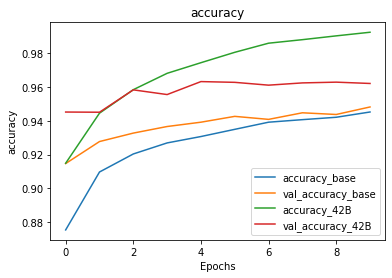

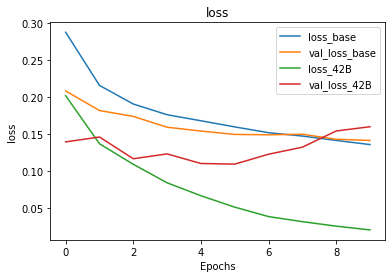

In [48]:
# Plot comparison
for metric in ['accuracy','loss']:
    plt.title(metric)
    plt.plot(history_base.history[metric])
    plt.plot(history_base.history['val_'+metric])
    plt.plot(history_cmp2.history[metric])
    plt.plot(history_cmp2.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric+'_base','val_'+metric+'_base',metric+'_42B', 'val_'+metric+'_42B'])
    plt.show()

By using a more elaborate embedding, the performance of the base model is far greater than the base model, although the training times are much longer, as the embedding dimensions and therefore the network structure have increased.

# Feature Engineering

A feature engineering is done to see which effect it has on the base model.

In [49]:
# Coppy of df from data processing to carry out Feature Engineering
df_fe = copy.deepcopy(df)

## Enriching the Title

An approach that may give greater accuracy is to enrich the title with words from the body of the news (*text_clean*). We want to add only those words from the text item that are not contained in *title_clean*. That is to say, mix both columns and select unique words, preserving the order.

In [50]:
# Mix both title and text
df_fe['title_enriched'] = df_fe['title_clean'] + ' ' + df_fe['text_clean']

# Remove duplicated words, preserving the order
df_fe['title_union_text'] = (df_fe['title_enriched'].str.split()\
                             .apply(lambda x: collections.OrderedDict.fromkeys(x).keys())\
                             .str.join(' '))

In [51]:
# '.sample(frac=1)': Prior to modeling, it is a good practice to
#                    randomly order the rows of the dataset.
df_fe = df_fe.sample(frac=1).reset_index(drop=True)

In [52]:
y = df_fe[target]
x = df_fe['title_union_text']
training_portion = 0.8

label_distinct = len(set(y)) # this might be use as a dynamic parameter for the cost function layer (number of output neurons)
print('Distinct categories in train set :' + str(label_distinct))

train_size = int(len(y) * training_portion)

x_train = x[0: train_size]
y_train = y[0: train_size]
x_val = x[train_size:]
y_val = y[train_size:]

print('x_train records :' + str(len(x_train)))
print('y_train records :' + str(len(y_train)))
print('x_val records :' + str(len(x_val)))
print('y_val records :' + str(len(y_val)))

Distinct categories in train set :2
x_train records :35918
y_train records :35918
x_val records :8980
y_val records :8980


In [53]:
vocab_size = 15000 # max tokens to be considered in vocabulary based on frequency
oov_tok = '<OOV>'  # Out Of Vocabulary

In [54]:
label_tokenizer = Tokenizer() # Tokenizer is a functionality from tensorflow wich transforms words into numbers. Once a word
# has been converted to a number, every consecutive upcoming word already seen is converted to the same number
# This process is called tokenization
label_tokenizer.fit_on_texts(y_train) # fit will return a dictionary
label_index = label_tokenizer.word_index # save indexes for reverse transformation

# Tokenizer indexes from 1 to p, where p is number of categories.
# Is useful to substract 1 in order to start from 0 instead of 1. This way the final Dense layer doesnt need a dummy.
for k in label_index:
    label_index[k] -= 1
print('label_index' + str(label_index))

# As opposose to labels, Tokenizer for text has to be parametrized
tokenizer = Tokenizer(num_words = vocab_size # max words to be considered
                      , oov_token=oov_tok) #I want "OOV" in bracket to be used to for words that are not in the word index.
tokenizer.fit_on_texts(x_train) # fit will return a dictionary
word_index = tokenizer.word_index # save indexes for reverse transformation
len_word_index = len(word_index)

print('This is an example for 5 tokens in the word_index :' + str(dict(list(word_index.items())[0:5])))

label_index{'fake': 0, 'true': 1}
This is an example for 5 tokens in the word_index :{'<OOV>': 1, 'said': 2, 'president': 3, 'would': 4, 'trump': 5}


From clean text we have shifted to its coding. This is what is going to enter into NN:

In [55]:
# Once the tokenizer has been fitted, we transform our actual data
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

y_train_seq = np.array(y_train.map(label_index))
y_val_seq = np.array(y_val.map(label_index))

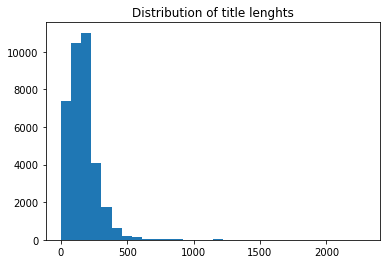

Maximum number of tokens per text:  550


In [56]:
# BY MY OWN CHOICE: Adjust the maximum number of tokens per text according to
# the upper outliers boundary. We do not select the maximum as previously,
# as this would exponentially increase the computational cost.

lenghts_ = []

for title in x_train_seq:
    lenghts_.append(len(title))

lenghts_ = np.array(lenghts_)

# Plot distribution of lenghts
plt.title('Distribution of title lenghts')
n, bins, patches = plt.hist(lenghts_, bins=30)
plt.show()

q1, q3 = np.percentile(lenghts_, [25, 75])
iqr = q3 - q1
# Upper outlier boundary: 3 standard deviations away from the mean
max_length = int(q3 + (iqr * 3))

trunc_type = 'post' # If the number of tokens per text is exceeded, it is truncated.
padding_type = 'post' # If short, 0s are added.

print('Maximum number of tokens per text: ',max_length)

x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [57]:
pre_trained_embedding = "glove.6B.50d.txt"
embedding_dim = 50  # embedding dimension

# transform embedding using tokenized indexes. This is, transform the embedded word into same 
# token your data had

embeddings_index = {}

# Parse embedding
f = open(pre_trained_embedding, encoding="utf8")
for line in f:
    values = line.split() # the actual vector representation
    word = values[0] # the original word
    # place vector representation in the value where "key" equals "word"
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len_word_index + 1, embedding_dim))

# Store words not found in the embedding.
not_found_words = []

for word, i in word_index.items(): # for each word in word_index dictionary
    embedding_vector = embeddings_index.get(word)# capture vector reprsntation using "word" as key
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        not_found_words.append(word)
        
print(len(not_found_words), " of the words have not been found in", pre_trained_embedding)

30941  of the words have not been found in glove.6B.50d.txt


**Train the model with the new 'feature-engineered' data**. As we can see in the model summary, the number of neurons params increases considerably, which translates into longer training times. Also the # of words not found in the embedding has logically increased.

In [58]:
model_fe = make_model2(dense_layers_ = 1
                         , loss_ = 'binary_crossentropy'
                         , lr_ = 0.001
                         , dense_dropout_ = 0.01
                         , verbose = 1)

history_fe = model_fe.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , batch_size=16                          
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=1)

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.01
lr :0.001
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 550, 50)           5131900   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 550, 50)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_7 (Bidirectio  (None, 550, 100)         40400     
 nal)                                                            
                                                                 
 global_average_pooling1d_6   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)      

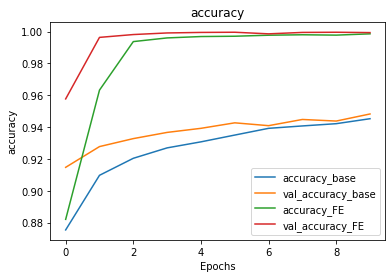

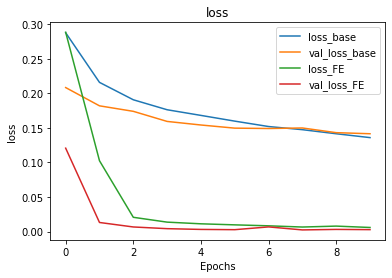

In [59]:
# Plot comparison
for metric in ['accuracy','loss']:
    plt.title(metric)
    plt.plot(history_base.history[metric])
    plt.plot(history_base.history['val_'+metric])
    plt.plot(history_fe.history[metric])
    plt.plot(history_fe.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric+'_base','val_'+metric+'_base',metric+'_FE', 'val_'+metric+'_FE'])
    plt.show()

As we can appreciate in the graphs, Feature Engineering make it possible for the model to reach a validation accuracy close to 1 over the first few epochs, although training times are significantly longer than all previous models.

## Preserving Uppercases

Usually uppercase words are related to fake news, trying to get the user to do click-bait. Preserving letter cases distinction could be useful.

In [68]:
# pat1 = r'http[^ ]+' # pattern to remove links
# pat2 = r'www.[^ ]+' # pattern to remove links
# pat3 = '[^a-zA-Z]+' # pattern to remove numbers
# pat = r'|'.join((pat1, pat2, pat3))

# def get_clean_text_preserveUP(text):
#     text = re.sub(pat, ' ', text) # remove pat
#     text = [w for w in tok.tokenize(text) if not w.lower() in stop_words] # remove stop_words
#     text = [w for w in text if len(w)>1] # remove words with len <2
#     text = (' '.join(text)).strip() # list to string
#     return text

# df['text_clean_fe'] = [get_clean_text_preserveUP(t) for t in df['text']]
# df['title_clean_fe'] = [get_clean_text_preserveUP(t) for t in df['title']]

An attempt has been made to train a classifier with this data. However, the embedding dimensions grow **dramatically** and hence the training time according to the selected architecture. So it is proposed to be done as future work.